In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from emmental.data import EmmentalDataLoader, EmmentalDataset
from emmental.emmental_model import EmmentalModel
from emmental.learner import EmmentalLearner
from emmental.task import Task

### Generate data

In [2]:
N = 200
X = np.random.random((N, 2)) * 2 - 1
Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

In [3]:
# categorical labels: 
Y1_mask = Y == 1
Y2_mask = Y == 2

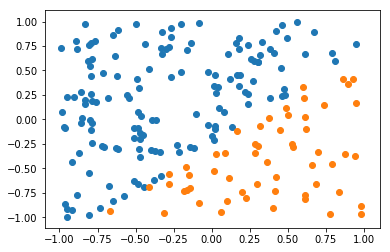

In [4]:
plt.scatter(X[Y1_mask, 0], X[Y1_mask, 1])
plt.scatter(X[Y2_mask, 0], X[Y2_mask, 1])
plt.show()

### Create tasks

In [5]:
def mse_loss(immediate_ouput, Y):
    mse = nn.MSELoss()
    return mse(immediate_ouput[-1][0].view(-1), Y.view(-1))

In [6]:
def ce_loss(immediate_ouput, Y):
#     F.cross_entropy(X["data"], Y.view(-1) - 1))
#     ce = nn.BCELoss()
#     print(immediate_ouput[-1][0].size(), Y.size())
    return F.cross_entropy(immediate_ouput[-1][0], Y.view(-1) - 1)

In [7]:
def output(immediate_ouput):
    return immediate_ouput[-1][0]

In [8]:
task1 = Task(
    name="task1",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module1": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 0)]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module1", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
)

In [9]:
task2 = Task(
    name="task2",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module2": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 0)]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module2", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
)

In [10]:
mtl_model = EmmentalModel(name = 'all', tasks=[task1, task2])

### Generate dataloader

In [11]:
splits = [0.8, 0.1, 0.1]

X_train, X_dev, X_test = [], [], []
Y_train, Y_dev, Y_test = [], [], []

for i in range(N):
    if i <= N * splits[0]:
        X_train.append(torch.Tensor(X[i]))
        Y_train.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    elif i < N * (splits[0] + splits[1]):
        X_dev.append(torch.Tensor(X[i]))
        Y_dev.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    else:
        X_test.append(torch.Tensor(X[i]))
        Y_test.append(torch.Tensor([Y[i]]).type(torch.LongTensor))

In [12]:
train_dataset = EmmentalDataset({"data": X_train}, {"label": Y_train})
dev_dataset = EmmentalDataset({"data": X_dev}, {"label": Y_dev})
test_dataset = EmmentalDataset({"data": X_test}, {"label": Y_test})

In [13]:
train_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=train_dataset, label_name="label", split="train", batch_size=10
)
dev_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=dev_dataset, label_name="label", split="dev", batch_size=10
)
test_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

In [14]:
train_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=train_dataset, label_name="label", split="train", batch_size=20
)
dev_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=dev_dataset, label_name="label", split="dev", batch_size=10
)
test_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

### Load config

In [15]:
from emmental.utils.config import load_config

In [16]:
config = load_config()

In [17]:
config

{'model_config': {'seed': None,
  'verbose': True,
  'device': 'cpu',
  'fp16': False,
  'model_path': None},
 'learner_config': {'seed': None,
  'verbose': True,
  'progress_bar': True,
  'n_epochs': 1,
  'optimizer_config': {'optimizer': 'adam',
   'lr': 0.001,
   'l2': 0.0,
   'grad_clip': 1.0,
   'sgd_config': {'momentum': 0.9},
   'adam_config': {'betas': (0.9, 0.999)}},
  'lr_scheduler_config': {'lr_scheduler': None},
  'task_scheduler': 'sequential'},
 'evaluation_config': None,
 'logging_config': {'log_unit': 'epoch', 'log_freq': 1.0}}

In [18]:
emmental_learner = EmmentalLearner(config)

In [19]:
new_config = {"learner_config": {"n_epochs": 10, "optimizer_config": {"lr": 0.01}}}

In [20]:
emmental_learner.learn(mtl_model, [train_dataloader1, train_dataloader2], config=new_config)

26


task1 0.6662676930427551
task1 0.5798705220222473
task1 0.5622360706329346
task1 0.5111991167068481
task1 0.4569341242313385
task1 0.4606378674507141
task1 0.4096677303314209
task1 0.5364471673965454
task1 0.45225030183792114
task1 0.475896418094635
task1 0.34893599152565
task1 0.5249070525169373
task1 0.42223721742630005
task1 0.3487916588783264
task1 0.5100696682929993
task1 0.3175644874572754
task1 1.0314267873764038
task2 0.49119219183921814
task2 0.5390346646308899
task2 0.5447746515274048
task2 0.5063337683677673
task2 0.5384811162948608
task2 0.4611400067806244
task2 0.43069520592689514
task2 0.4629724621772766
task2 1.1371920108795166



task1 0.20963898301124573
task1 0.14895546436309814
task1 0.17469295859336853
task1 0.18763446807861328
task1 0.06426630914211273
task1 0.1034310907125473
task1 0.3018302321434021
task1 0.2780400812625885
task1 0.22668245434761047
task1 0.15046828985214233
task1 0.16246114671230316
task1 0.31950491666793823
task1 0.21776695549488068
task1 0.17477425932884216
task1 0.19913902878761292
task1 0.18207614123821259
task1 0.31600552797317505
task2 0.14377924799919128
task2 0.14353476464748383
task2 0.07419794052839279
task2 0.27991586923599243
task2 0.17073063552379608
task2 0.19805845618247986
task2 0.19961431622505188
task2 0.19618085026741028
task2 0.30724599957466125



task1 0.0449189655482769
task1 0.07584686577320099
task1 0.037968188524246216
task1 0.08543180674314499
task1 0.005534493830054998
task1 0.08912049233913422
task1 0.3077046275138855
task1 0.19159036874771118
task1 0.14494620263576508
task1 0.029565226286649704
task1 0.06154099106788635
task1 0.11798377335071564
task1 0.15354086458683014
task1 0.08196982741355896
task1 0.1078474149107933
task1 0.11466357856988907
task1 0.055971741676330566
task2 0.05864458531141281
task2 0.0597681999206543
task2 0.03517431393265724
task2 0.23384086787700653
task2 0.08700244128704071
task2 0.10719859600067139
task2 0.12658141553401947
task2 0.1229495257139206
task2 0.09952068328857422



task1 0.010001909919083118
task1 0.04564859718084335
task1 0.03068617545068264
task1 0.031249230727553368
task1 0.0015290736919268966
task1 0.053640544414520264
task1 0.22699160873889923
task1 0.16233572363853455
task1 0.06499911844730377
task1 0.026726096868515015
task1 0.0492289774119854
task1 0.12209896743297577
task1 0.12909826636314392
task1 0.04055783152580261
task1 0.07088513672351837
task1 0.11456668376922607
task1 0.01595282554626465
task2 0.032410770654678345
task2 0.04156062752008438
task2 0.02813895046710968
task2 0.19744354486465454
task2 0.05882761999964714
task2 0.09251900017261505
task2 0.09826339036226273
task2 0.09922915697097778
task2 0.03979825973510742



task1 0.0031077146995812654
task1 0.02904236875474453
task1 0.02653132751584053
task1 0.017496954649686813
task1 0.00044817925663664937
task1 0.037199802696704865
task1 0.19922442734241486
task1 0.15893110632896423
task1 0.03757091611623764
task1 0.022829443216323853
task1 0.04326746612787247
task1 0.12065503746271133
task1 0.11765687167644501
task1 0.0258687324821949
task1 0.056481730192899704
task1 0.11676677316427231
task1 0.005316257476806641
task2 0.022380618378520012
task2 0.03132431209087372
task2 0.025724688544869423
task2 0.17745013535022736
task2 0.04289711266756058
task2 0.0809738039970398
task2 0.08372608572244644
task2 0.08773883432149887
task2 0.018135905265808105



task1 0.0011174678802490234
task1 0.020560836419463158
task1 0.018335770815610886
task1 0.013294780626893044
task1 0.00012419224367477
task1 0.035016901791095734
task1 0.18580079078674316
task1 0.14194467663764954
task1 0.02680736780166626
task1 0.016673505306243896
task1 0.04321227967739105
task1 0.11342725902795792
task1 0.11025746166706085
task1 0.017809856683015823
task1 0.050611577928066254
task1 0.1084999293088913
task1 0.0022428035736083984
task2 0.016038503497838974
task2 0.024104196578264236
task2 0.021572295576334
task2 0.16121967136859894
task2 0.032083503901958466
task2 0.07616524398326874
task2 0.07388551533222198
task2 0.07954776287078857
task2 0.00953829288482666



task1 0.0004427909734658897
task1 0.015554999932646751
task1 0.012962055392563343
task1 0.011897814460098743
task1 3.228187415516004e-05
task1 0.033824458718299866
task1 0.1668110191822052
task1 0.1210562214255333
task1 0.020559703931212425
task1 0.012152815237641335
task1 0.04537626728415489
task1 0.10909686237573624
task1 0.10452105849981308
task1 0.01240086555480957
task1 0.04868777468800545
task1 0.09509424865245819
task1 0.0010137557983398438
task2 0.012034863233566284
task2 0.018956368789076805
task2 0.018911730498075485
task2 0.15088149905204773
task2 0.024781426414847374
task2 0.07150261104106903
task2 0.06802301108837128
task2 0.0738946944475174
task2 0.005008220672607422



task1 0.00018379688845016062
task1 0.012143993750214577
task1 0.009290968999266624
task1 0.010411310009658337
task1 9.202956789522432e-06
task1 0.03287240117788315
task1 0.15373492240905762
task1 0.10445930808782578
task1 0.016145050525665283
task1 0.008820521645247936
task1 0.04673026502132416
task1 0.10558440536260605
task1 0.09975752979516983
task1 0.00882643461227417
task1 0.04748877137899399
task1 0.0835983157157898
task1 0.00045371055603027344
task2 0.00944404024630785
task2 0.015277487225830555
task2 0.017582181841135025
task2 0.14221376180648804
task2 0.01964072324335575
task2 0.06726576387882233
task2 0.06377372145652771
task2 0.06952429562807083
task2 0.002626657485961914



task1 7.817745063221082e-05
task1 0.009448480792343616
task1 0.0069155097007751465
task1 0.008650755509734154
task1 2.86102294921875e-06
task1 0.030799806118011475
task1 0.14350685477256775
task1 0.09266164153814316
task1 0.012548565864562988
task1 0.0065235854126513
task1 0.04760392755270004
task1 0.10327265411615372
task1 0.09549587965011597
task1 0.0064241886138916016
task1 0.04568774998188019
task1 0.0750904530286789
task1 0.00020122528076171875
task2 0.007637768983840942
task2 0.01252329908311367
task2 0.01679259166121483
task2 0.1339074969291687
task2 0.01582241989672184
task2 0.06372970342636108
task2 0.06027437001466751
task2 0.0657774955034256
task2 0.0013904571533203125



task1 3.4046173823298886e-05
task1 0.007316887378692627
task1 0.00525555619969964
task1 0.006951821036636829
task1 9.5367431640625e-07
task1 0.02836722694337368
task1 0.13516397774219513
task1 0.08350954949855804
task1 0.009749019518494606
task1 0.0048438785597682
task1 0.048541124910116196
task1 0.10121673345565796
task1 0.09166283160448074
task1 0.004761302378028631
task1 0.043528422713279724
task1 0.0681484118103981
task1 9.012222290039062e-05
task2 0.0062701525166630745
task2 0.010384571738541126
task2 0.016012197360396385
task2 0.12613490223884583
task2 0.012852087616920471
task2 0.061153750866651535
task2 0.05724456161260605
task2 0.06232570484280586
task2 0.0007476806640625

